# 基于LangGraph构架一个简单的邮件分类器

In [12]:
import os
from typing import TypedDict, List, Dict, Any, Optional

from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage

from based_on_openai_model import ChatINTERNLM

load_dotenv()

True

## 步骤1：定义状态

In [22]:
class EmailState(TypedDict):
    # 正在处理的电子邮件
    email: Dict[str, Any]  # 包含主题、发件人、正文等。
    
    # 分析与决策
    is_spam: Optional[bool]
    spam_reason: Optional[str]
    email_category: Optional[str]
    
    # 响应生成
    draft_response: Optional[str]
    
    # 处理元数据
    messages: List[Dict[str, Any]]  # 跟踪与 LLM 的对话以进行分析

- 注意：状态的定义需要尽可能全面以跟踪所有的重要信息，但也避免不必要的细节使其变得臃肿

## 步骤2：定义节点

In [3]:
model = ChatINTERNLM(model="intern-latest", temperature=0.0)

In [4]:
model.invoke("你好，你是谁？")

AIMessage(content='你好！我是Intern-S1，来自上海人工智能实验室。我是一个智能助手，旨在为你提供知识解答、问题分析以及各种任务的支持。如果你有任何问题或需要帮助，请随时告诉我！', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 149, 'prompt_tokens': 162, 'total_tokens': 311, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'Intern-S1', 'system_fingerprint': None, 'id': '3khujQGWCx0P_6vEMDXY1YpPQh1Z89ONciSGUKmgFFA=', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--fddaea29-6a11-41f9-b2a0-ed63496f9128-0', usage_metadata={'input_tokens': 162, 'output_tokens': 149, 'total_tokens': 311, 'input_token_details': {}, 'output_token_details': {}})

- 先创建构建节点的处理函数

In [23]:
def read_email(state: EmailState):
    r"""read and log the incoming email"""
    email = state["email"]
    
    # 在这里可能会做一些初步的预处理
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # 这里不需要更改状态
    return {}


def classify_email(state: EmailState):
    """use an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # 为 LLM 准备提示词
    prompt = f"""
    As Alfred the butler, analyze this email and determine if it is spam or legitimate.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # 解析响应的简单逻辑（在实际应用中，需要更强大的解析）
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # 如果是垃圾邮件，请提取原因
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # 确定类别是否合法
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # 更新消息以进行追踪
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # 返回状态更新
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }


def handle_spam(state: EmailState):
    """discard spam email with a note"""
    print(f"Alfred has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # 已处理完这封电子邮件
    return {}


def draft_response(state: EmailState):
    """draft a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # 为 LLM 准备提示词
    prompt = f"""
    As Alfred the butler, draft a polite preliminary response to this email.
    
    Email:
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that Mr. Hugg can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # 更新消息以进行追踪
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # 返回状态更新
    return {
        "draft_response": response.content,
        "messages": new_messages
    }


def notify_mr_hugg(state: EmailState):
    """Alfred notifies Mr. Hugg about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["draft_response"])
    print("="*50 + "\n")
    
    # 已处理完这封电子邮件
    return {}

## 步骤3：定义路由逻辑

- 需要定义一个函数来确定邮件分类后采取哪条路径
- 注意： LangGraph调用此路由函数来确定在分类节点之后要跟随哪条边；返回值必须与条件边映射中的一个键匹配。

In [24]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

## 步骤4：创建StateGraph并定节点、边

In [25]:
# 创建graph
email_graph = StateGraph(EmailState)


In [26]:
# 添加nodes，就是将定义的处理函数和一个对应的节点绑定，会给节点设置一个节点名
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify_mr_hugg", notify_mr_hugg)

In [27]:
# 添加edges，即使用使用两个节点名代表对应的节点，在两个节点直接建立有向边
email_graph.add_edge("read_email", "classify_email")

# 从classify_email添加条件分支
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# 添加最后的edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify_mr_hugg")
email_graph.add_edge("notify_mr_hugg", END)

# 添加入口节点
email_graph.add_edge(START, "read_email")

# 编译graph
compiled_graph = email_graph.compile()

## 步骤5：运行

- 以下用一封合法邮件和一封非合法邮件进行测试

In [28]:
# 合法电子邮件示例
legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Mr. Hugg, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

# 垃圾邮件示例
spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

# 处理合法电子邮件
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
    "messages": []
})

# 处理垃圾邮件
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "draft_response": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from john.smith@example.com with subject: Question about your services
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.

Processing spam email...
Alfred is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.


## 步骤6：使用LangFuse跟踪邮件分类器整个运行过程

- 需要先安装langfuse：pip install -q langfuse
- 在LangFuse网站创建账号、组织、项目，在项目的设置页面创建apikey

In [29]:
from langfuse.langchain import CallbackHandler

# 为LangGraph/Langchain初始化Langfuse CallbackHandler（跟踪）
langfuse_handler = CallbackHandler()

# 处理合法电子邮件
legitimate_result = compiled_graph.invoke(
    input={"email": legitimate_email, "is_spam": None, "spam_reason": None, "email_category": None, "draft_response": None, "messages": []},
    config={"callbacks": [langfuse_handler]}
)

Alfred is processing an email from john.smith@example.com with subject: Question about your services
Alfred has marked the email as spam. Reason: None
The email has been moved to the spam folder.


- 可视化工作流程

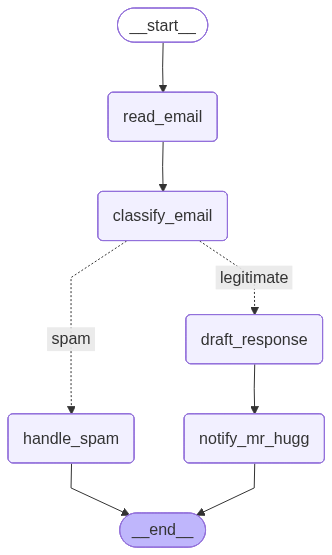

In [35]:
from IPython.display import Image, display
import base64

image_bytes = compiled_graph.get_graph().draw_mermaid_png()

# 直接显示
display(Image(image_bytes))